In [6]:
import fairlearn.metrics
import numpy as np
from sklearn.metrics import accuracy_score
import time
import pandas as pd
from pprint import pprint
from dl85 import DL85Classifier
import graphviz
import MyCode.utils as utils
"""
dataset = np.genfromtxt("datasets/anneal.txt", delimiter=' ')
X, y = dataset[:, 1:], dataset[:, 0]

"""
col1        = np.array([0.0] * 10 + [1.0] * 0 + [0.0] * 0 + [1.0] * 10).reshape(-1,1)
col2        = np.array([0.0] * 5 + [1.0] * 5 + [0.0] * 5 + [1.0] * 5).reshape(-1,1)
X           = np.array([0.0] * 10 + [1.0] * 0 + [0.0] * 0 + [1.0] * 10)
X           = np.concatenate( (col1, col2), axis = 1)

y           = np.array([0.0] * 8 + [1.0] * 2 + [0.0] * 2 + [1.0] * 8)
#sensitive   = np.array([0.0] * 6 + [1.0] * 5 + [0.0] * 7 + [1.0] * 2)
sensitive   = np.array([1.0] * 6 + [0.0] * 5 + [1.0] * 7 + [0.0] * 2)
#X_train,y_train = X, y

#DATAFRAME
df = pd.DataFrame(X)
df['Class'] = y.tolist()
df['Sensitive'] = sensitive.tolist()
df

,0,1,Class,Sensitive
0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0
5,0.0,1.0,0.0,1.0
6,0.0,1.0,0.0,0.0
7,0.0,1.0,0.0,0.0
8,0.0,1.0,1.0,0.0
9,0.0,1.0,1.0,0.0


In [7]:
utils.discrimination(df['Class'], df['Sensitive'] )

0.10989010989010983

In [8]:
def train_test_split(random_state):
    global X_train, y_train, sensitive_train
    global X_test, y_test, sensitive_test

    X = df.loc[:, ~df.columns.isin(['Class', 'Sensitive'])]
    y = df['Class']
    sensitive = df['Sensitive']

    index_train = list(df.sample(frac=1, random_state=random_state).index)
    index_test = list(df.drop(index=index_train).index)

    X_train = X.drop(index=index_test).to_numpy()
    y_train = y.drop(index=index_test).to_numpy()
    sensitive_train = sensitive.drop(index=index_test).to_numpy()

    X_test = X.drop(index=index_train).to_numpy()
    y_test = list(y.drop(index=index_train).to_numpy())
    sensitive_test = sensitive.drop(index=index_train).to_numpy()
train_test_split(1)

In [9]:
def discrimination(sensitive, y):
    """
    p0: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 0, clf(𝑥) = +}∣
    p1: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 1, clf(𝑥) = +}∣
    n_zero: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 0}∣
    n_one: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 1}∣
    """
    p0, p1, n_zero, n_one= 0, 0, 0, 0
    for i in range(0, len(y)):
        if sensitive[i] == 0.0:
            n_zero+=1
            if y[i] == 1.0:
                p0+=1
        elif sensitive[i] == 1.0:
            n_one+=1
            if y[i] == 1.0:
                p1+=1

    if n_one == 0 and n_zero == 0: d = 0
    elif n_zero == 0: d = -(p1/n_one)
    elif n_one == 0: d = p0/n_zero
    else: d = (p0/n_zero) - (p1/n_one)

    #A higher discrimination means that tuples with
    #Sensitive = 1 are less likely to be classified as positive
    return d

def discr_add(tids):
    """
    p0: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 0, 𝑥.Class = +}∣
    p1: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 1, 𝑥.Class = +}∣
    n_zero: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 0}∣
    n_one: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 1}∣
    """
    p0, p1 = 0, 0
    for i in tids:
        if sensitive_train[i] == 0.0:
            if y_train[i] == 1.0:
                p0+=1
        elif sensitive_train[i] == 1.0:
            if y_train[i] == 1.0:
                p1+=1

    cnt = np.unique(sensitive_train, return_counts=True)[1]
    n_zero = cnt[0]
    n_one = cnt[1]

    if n_one == 0 and n_zero == 0: d = 0
    elif n_zero == 0: d = -(p1/n_one)
    elif n_one == 0: d = p0/n_zero
    else: d = (p0/n_zero) - (p1/n_one)

    #A higher discrimination means that tuples with
    #Sensitive = 1 are less likely to be classified as positive
    return d

def misclassified(tids):
    classes, supports = np.unique(y_train.take(tids), return_counts=True)
    maxindex = np.argmax(supports)

    return sum(supports) - supports[maxindex], classes[maxindex]

def error(tids, k):
    mis = misclassified(tids)
    return mis[0] + abs(discr_add(tids)) * k, mis[1]

def error1(tids, k):
    mis = misclassified(tids)
    return mis[0] + abs(discr_add(tids)) * k, mis[1]

def error2(tids, k):
    mis = misclassified(tids)
    return mis[0] + abs(discr_add(tids)) * k, mis[1]

def error3(tids, k):
    mis = misclassified(tids)
    return mis[0] + abs(discr_add(tids)) * k, mis[1]

def error4(tids, k):
    mis = misclassified(tids)
    return mis[0] + abs(discr_add(tids)) * k, mis[1]

In [10]:
train_test_split(1)

clf = DL85Classifier(max_depth=2, error_function=lambda tids: error(list(tids), 1), time_limit=600)

start = time.perf_counter()
print("Model building...")
clf.fit(X_train, y_train)
duration = time.perf_counter() - start
print("Model built. Duration of building =", round(duration, 4))
print("Accuracy DL8.5 on training set =", round(clf.accuracy_, 4))
y_pred = clf.predict(X_train)
print("Average accuracy on test set =", accuracy_score(y_train, y_pred))
descrimation = round(discrimination(sensitive_train, y_pred), 4)
print("Discrimination of classifier", round(discrimination(sensitive_train, y_pred), 4))

print(f"error: {clf.error_}")

Model building...
Model built. Duration of building = 0.0032
Accuracy DL8.5 on training set = 0.7714
Average accuracy on test set = 0.8
Discrimination of classifier -0.1099
error: 4.571428


In [11]:
from dl85 import DL85Predictor

clf = DL85Predictor(
    max_depth=5,
    min_sup=0,
    error_function=lambda tids: error(list(tids), 1),
    fast_error_function=None,
    max_error=0,
    stop_after_better=False,
    time_limit=600,
    verbose=False,
    desc=False,
    asc=False,
    repeat_sort=False,
    quiet=True,
    print_output=True)
clf.fit(X_train, list(y_train))

(nItems, nTransactions) : ( 4, 20 )
Tree: {'feat': 0, 'left': {'feat': 1, 'left': {'value': 1, 'error': 0.054945, 'transactions': [15, 16, 17, 18, 19], 'proba': [0, 1.0]}, 'right': {'value': 1, 'error': 2.230769, 'transactions': [10, 11, 12, 13, 14], 'proba': [0.4, 0.6]}, 'transactions': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'proba': [0.2, 0.8]}, 'right': {'feat': 1, 'left': {'value': 0, 'error': 2.285714, 'transactions': [5, 6, 7, 8, 9], 'proba': [0.6, 0.4]}, 'right': {'value': 0, 'error': 0.0, 'transactions': [0, 1, 2, 3, 4], 'proba': [1.0, 0]}, 'transactions': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'proba': [0.8, 0.2]}, 'transactions': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'proba': [0.5, 0.5]}
Size: 7
Depth: 2
Error: 4.571428
LatticeSize: 9
Runtime: 0.003747
Timeout: False


DL85Predictor(error_function=<function <lambda> at 0x7fd5b30898b0>, max_depth=5,
              min_sup=0, print_output=True, time_limit=600)

In [12]:
clf = DL85Predictor(max_depth=5, error_function=lambda tids: error1(list(tids), 1), min_sup=0, time_limit=600, print_output = True)
clf.fit(X_train, list(y_train))
pprint(clf.tree_)

(nItems, nTransactions) : ( 4, 20 )
Tree: {'feat': 0, 'left': {'feat': 1, 'left': {'value': 1, 'error': 0.054945, 'transactions': [15, 16, 17, 18, 19], 'proba': [0, 1.0]}, 'right': {'value': 1, 'error': 2.230769, 'transactions': [10, 11, 12, 13, 14], 'proba': [0.4, 0.6]}, 'transactions': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'proba': [0.2, 0.8]}, 'right': {'feat': 1, 'left': {'value': 0, 'error': 2.285714, 'transactions': [5, 6, 7, 8, 9], 'proba': [0.6, 0.4]}, 'right': {'value': 0, 'error': 0.0, 'transactions': [0, 1, 2, 3, 4], 'proba': [1.0, 0]}, 'transactions': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'proba': [0.8, 0.2]}, 'transactions': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'proba': [0.5, 0.5]}
Size: 7
Depth: 2
Error: 4.571428
LatticeSize: 9
Runtime: 0.002668
Timeout: False
{'feat': 0,
 'left': {'feat': 1,
          'left': {'error': 0.054945,
                   'proba': [0, 1.0],
                   'transactions': [15, 16, 17, 18, 19],
                

In [13]:
def tree_upgrade(tree):
    if 'feat' in tree:
        tree_upgrade(tree['left'])
        tree_upgrade(tree['right'])
    else:
        tree['discrimination_additive'] = discr_add(tree['transactions'])
        tree['misclassified'] = misclassified(tree['transactions'])[0]
tree_upgrade(clf.tree_)
pprint(clf.tree_)

{'feat': 0,
 'left': {'feat': 1,
          'left': {'discrimination_additive': 0.054945054945054916,
                   'error': 0.054945,
                   'misclassified': 0,
                   'proba': [0, 1.0],
                   'transactions': [15, 16, 17, 18, 19],
                   'value': 1},
          'proba': [0.2, 0.8],
          'right': {'discrimination_additive': -0.23076923076923078,
                    'error': 2.230769,
                    'misclassified': 2,
                    'proba': [0.4, 0.6],
                    'transactions': [10, 11, 12, 13, 14],
                    'value': 1},
          'transactions': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]},
 'proba': [0.5, 0.5],
 'right': {'feat': 1,
           'left': {'discrimination_additive': 0.2857142857142857,
                    'error': 2.285714,
                    'misclassified': 2,
                    'proba': [0.6, 0.4],
                    'transactions': [5, 6, 7, 8, 9],
                    'value': 0}

In [14]:
from MyCode.utils import export_graphviz

dot = export_graphviz(clf)
graph = graphviz.Source(dot, format="png")
graph.render("plots/discrimination_tree")

'plots/discrimination_tree.png'

[Text(251.10000000000002, 271.8, 'X[0] <= 0.5\ngini = 0.5\nsamples = 20\nvalue = [10, 10]'),
 Text(125.55000000000001, 163.08, 'X[1] <= 0.5\ngini = 0.32\nsamples = 10\nvalue = [8, 2]'),
 Text(62.775000000000006, 54.360000000000014, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]'),
 Text(188.32500000000002, 54.360000000000014, 'gini = 0.48\nsamples = 5\nvalue = [3, 2]'),
 Text(376.65000000000003, 163.08, 'X[1] <= 0.5\ngini = 0.32\nsamples = 10\nvalue = [2, 8]'),
 Text(313.875, 54.360000000000014, 'gini = 0.48\nsamples = 5\nvalue = [2, 3]'),
 Text(439.42500000000007, 54.360000000000014, 'gini = 0.0\nsamples = 5\nvalue = [0, 5]')]

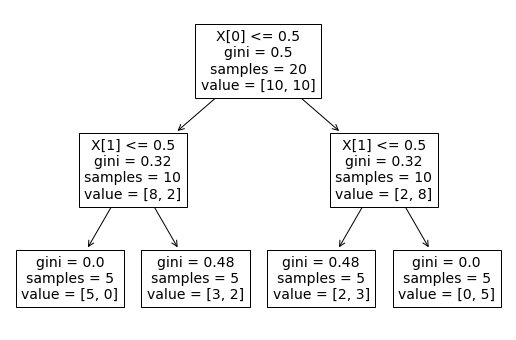

In [18]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=3, random_state=0)
clf.fit(X_train, list(y_train))
y_pred_train = clf.predict(X_train)
tree.plot_tree(clf)